In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

## Calibração pelo Octave

![alt text](./octave/grid_corners.jpg "Title")
![alt text](./octave/calibration_result_extrinsic_camera_centered.jpg "Title")
![alt text](./octave/calibration_result_extrinsic_world_centered.jpg)
![alt text](./octave/calibration_result_intrinsic.jpg "Title")
![alt text](./octave/calibration_result_extrinsic.jpg "Title")

In [2]:
def to_homo(coord):
    return np.append(coord, 1)

def from_homo_2d(homo_coord):
    return np.array([ homo_coord[0]/homo_coord[2], homo_coord[1]/homo_coord[2] ])

In [4]:
class CameraModel:
    def __init__(self, R, T, f, c):
        self.Mint = np.array([
            [f[0], 0, c[0], 0],
            [0, f[1], c[1], 0],
            [0,  0,  1, 0]
        ])
        self.Mext = np.zeros((4,4))
        self.Mext[0:3,0:3] = R
        self.Mext[0:3,3] = T
        self.Mext[3,3] = 1
        print(self.Mint)
        print(self.Mext)
        
    def project_world_point(self, world_point):
        t = world_point
        if world_coord.shape[0] == 3: #homogenize
            t = to_homo(world_point)
        homo_res = self.Mint.dot(self.Mext).dot(t)
        return from_homo_2d(homo_res)

## OCTAVE PARAMETERS ##
f = np.array([1045.73, 1062.27])
c = np.array([639.50, 475.50])
R = np.array([
    [0.763311, 0.642743, -0.065099],
    [0.350098, -0.496238, -0.794468],
    [-0.542943, 0.583635, -0.603807]
])
T = np.array([ -217.467313, -51.212003, 457.262331])

octaveModel = CameraModel(R,T,f,c)

[[1.04573e+03 0.00000e+00 6.39500e+02 0.00000e+00]
 [0.00000e+00 1.06227e+03 4.75500e+02 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]
[[ 7.63311000e-01  6.42743000e-01 -6.50990000e-02 -2.17467313e+02]
 [ 3.50098000e-01 -4.96238000e-01 -7.94468000e-01 -5.12120030e+01]
 [-5.42943000e-01  5.83635000e-01 -6.03807000e-01  4.57262331e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(960, 1280, 3)


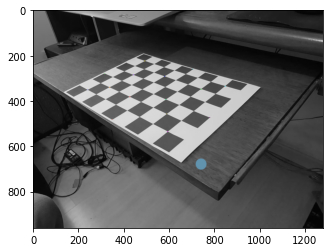

In [60]:
input_image = cv2.imread('./inputs/AnInput01.tif', cv2.IMREAD_COLOR)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
print(input_image.shape)
plt.imshow(input_image)

In [6]:
points = {
    1: { 'color': np.array([255, 0, 255]), 'position': np.array([240, 30, 1])},
    2: { 'color': np.array([0, 255, 255]), 'position': np.array([240, 180, 2])},
    3: { 'color': np.array([255, 255, 0]), 'position': np.array([30, 180, 3])},
    4: { 'color': np.array([255, 127, 0]), 'position': np.array([60, 60, -1])},
    5: { 'color': np.array([255, 0, 0]), 'position': np.array([120, 60, 2])},
    6: { 'color': np.array([0, 0, 255]), 'position': np.array([120, 150, 3])},
    7: { 'color': np.array([0, 255, 0]), 'position': np.array([210, 150, 1])},
    8: { 'color': np.array([0, 255, 127]), 'position': np.array([180, 90, 3])},
    9: { 'color': np.array([127, 0, 255]), 'position': np.array([60, 120, 2])},
    10: { 'color': np.array([127, 127, 0]), 'position': np.array([210, 60, 1])},
    11: { 'color': np.array([127, 127, 255]), 'position': np.array([30, 30, 3])},
    12: { 'color': np.array([255, 127, 127]), 'position': np.array([150, 0, 2])},
    13: { 'color': np.array([0, 127, 127]), 'position': np.array([150, 270, 0])},
    14: { 'color': np.array([127, 255, 127]), 'position': np.array([0, 90, 3])},
    15: { 'color': np.array([127, 0, 255]), 'position': np.array([270, 90, 2])}
}

In [7]:

def find_color_position(input_image, color):  
    h, w, c = input_image.shape
    acc_h = 0
    acc_w = 0
    total = 0
    for i_h in range(h):
        for i_w in range(w):
            if np.array_equal(input_image[i_h,i_w], color):
                acc_h = acc_h + i_h
                acc_w = acc_w + i_w
                total = total + 1
    if total > 0:
        pos_h = int(acc_h/total)
        pos_w = int(acc_w/total)
    return np.array([pos_w, pos_h]) # Troca posições para manter X e Y ao invés de linha coluna

point = 7
color = points[point]['color']
image_coord = find_color_position(input_image, color)
world_coord = points[point]['position']

print('---- Sampling point ----')
print('{} - ({}, {}) <- ({}mm, {}mm, {}mm)'.format(point, image_coord[0], image_coord[1], world_coord[0], world_coord[1], world_coord[2]))       
print('Checking consistency with model obtained from octave parameters')
octave_proj = octaveModel.project_world_point(world_coord)
print('    ({0:3.0f}, {1:3.0f})'.format(octave_proj[0], octave_proj[1]) )

---- Sampling point ----
7 - (742, 348) <- (210mm, 150mm, 1mm)
Checking consistency with model obtained from octave parameters
    (735, 345)


In [8]:
def A_row(i, w):
    return [
        i[0]*w[0],
        i[0]*w[1],
        i[0]*w[2],
        i[0],
        -i[1]*w[0],
        -i[1]*w[1],
        -i[1]*w[2],
        -i[1]
    ]
    
A_row(image_coord, world_coord)

[155820, 111300, 742, 742, -73080, -52200, -348, -348]

In [9]:
A = []
image_coords = []
world_coords = []
for point in points.keys():
    color = points[point]['color']
    image_coord = find_color_position(input_image, color)
    world_coord = points[point]['position']
    A.append(A_row(image_coord, world_coord))
    image_coords.append(image_coord)
    world_coords.append(world_coord)
A = np.array(A)

In [10]:
A

array([[ 142560,   17820,     594,     594, -128400,  -16050,    -535,
           -535],
       [ 203520,  152640,    1696,     848,  -80400,  -60300,    -670,
           -335],
       [  14790,   88740,    1479,     493,   -6720,  -40320,    -672,
           -224],
       [  20280,   20280,    -338,     338,  -20400,  -20400,     340,
           -340],
       [  51240,   25620,     854,     427,  -45840,  -22920,    -764,
           -382],
       [  69720,   87150,    1743,     581,  -34920,  -43650,    -873,
           -291],
       [ 155820,  111300,     742,     742,  -73080,  -52200,    -348,
           -348],
       [ 105480,   52740,    1758,     586,  -70740,  -35370,   -1179,
           -393],
       [  26640,   53280,     888,     444,  -17100,  -34200,    -570,
           -285],
       [ 123900,   35400,     590,     590,  -95970,  -27420,    -457,
           -457],
       [   7230,    7230,     723,     241,  -10530,  -10530,   -1053,
           -351],
       [  52350,     

In [11]:
U, S, V = np.linalg.svd(A)
print("Matriz U")
with np.printoptions(precision=3, suppress=True):
    print(U)
print("Matriz S")
with np.printoptions(precision=3, suppress=True):
    print(S)
print("Matriz V")
with np.printoptions(precision=3, suppress=True):
    print(V)

Matriz U
[[-0.311 -0.503  0.218  0.235  0.127  0.17   0.02   0.082  0.021 -0.427
   0.321 -0.319  0.026  0.28  -0.167]
 [-0.506  0.1   -0.553  0.016 -0.275  0.014 -0.411 -0.153  0.21   0.095
   0.054 -0.027  0.231  0.221 -0.033]
 [-0.129  0.351  0.372  0.049 -0.281  0.437 -0.14   0.197 -0.197  0.115
  -0.051 -0.42   0.182 -0.069  0.349]
 [-0.071  0.015  0.222 -0.271  0.54   0.092 -0.604 -0.383 -0.036 -0.051
  -0.151 -0.07  -0.095 -0.138 -0.033]
 [-0.138 -0.084  0.233 -0.193 -0.016 -0.117  0.048  0.014 -0.155 -0.18
  -0.033  0.38   0.797 -0.156 -0.065]
 [-0.223  0.179  0.138 -0.133 -0.29   0.307 -0.015 -0.136 -0.266 -0.124
   0.391  0.483 -0.384 -0.106 -0.233]
 [-0.394  0.032 -0.237 -0.158  0.2   -0.146 -0.04   0.634 -0.262 -0.249
  -0.256  0.036 -0.228 -0.202  0.086]
 [-0.261 -0.123  0.081 -0.25  -0.264  0.061  0.316 -0.214  0.115  0.062
  -0.46  -0.313 -0.078 -0.263 -0.476]
 [-0.116  0.158  0.265 -0.282  0.043  0.039  0.043  0.257  0.826 -0.074
   0.132  0.136 -0.062 -0.034  0.113]
 [

In [14]:
U, s, V = np.linalg.svd(A)
v = V.T[:, -1]
print(v)
gamma = np.sqrt( pow(v[0],2) + pow(v[1],2) + pow(v[2],2) )
print(gamma)
alpha = np.sqrt( pow(v[4],2) + pow(v[5],2) + pow(v[6],2) ) / gamma
print(alpha)
v = v / gamma
print(v)

[-3.61172469e-04 -6.80629378e-04 -8.42236365e-02  8.32189897e-01
  6.21934866e-04  3.74724017e-03 -9.63742868e-02  5.39502853e-01]
0.08422716095472994
1.1451070398322325
[-4.28807602e-03 -8.08087760e-03 -9.99958155e-01  9.88030331e+00
  7.38401792e-03  4.44896886e-02 -1.14421863e+00  6.40533109e+00]


In [15]:
R = np.zeros((3,3))
R[1,:] = v[0:3]
R[0,:] = v[4:7]/alpha
R[2,:] = np.cross(R[0,:],R[1,:])
T = np.zeros(2)
T[1] = v[3]
T[0] = v[7]/alpha
print(R)
print(T)

[[ 6.44832113e-03  3.88519912e-02 -9.99224170e-01]
 [-4.28807602e-03 -8.08087760e-03 -9.99958155e-01]
 [-4.69249736e-02  1.07328005e-02  1.14492198e-04]]
[5.59365271 9.88030331]


In [338]:
def arow2(i, w, R, T):
    return np.array([ 
        i[0],
        R[0,0]*w[0]+R[0,1]*w[1]+R[0,2]*w[2] + T[0]
    ])

Afinal = np.array([arow2(image_coords[i], world_coords[i], R, T) for i in range(len(image_coords))])
# print(Afinal)

def brow2(i, w, R):
    return np.array([ 
        -i[0]*(R[2,0]*w[0]+R[2,1]*w[1]+R[2,2]*w[2])
    ])

Bfinal = np.array([brow2(image_coords[i], world_coords[i], R) for i in range(len(image_coords))])
# print(Bfinal)
tf = np.linalg.inv(Afinal.T.dot(Afinal)).dot(Afinal.T).dot(Bfinal)
T = np.append(T,tf[0])
f = np.ones(2) * tf[1]
print(f)

[-521.00523995 -521.00523995]


In [341]:
myModel = CameraModel(R,T,f,c)
myModel.project_world_point(world_coords[7])

[[-521.00523995    0.          639.5           0.        ]
 [   0.         -521.00523995  475.5           0.        ]
 [   0.            0.            1.            0.        ]]
[[ 6.44832113e-03  3.88519912e-02 -9.99224170e-01  5.59365271e+00]
 [-4.28807602e-03 -8.08087760e-03 -9.99958155e-01  9.88030331e+00]
 [-4.69249736e-02  1.07328005e-02  1.14492198e-04  1.53037165e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


array([156.4643989 , 117.13385864])

In [209]:
r21 = v[0]
r22 = v[1]
r23 = v[2]
Ty =  v[3]
r11 = v[4]
r12 = v[5]
r13 = v[6]
Tx = v[7]


In [210]:
cross_prod = np.cross( np.array([r21, r22, r23]), np.array([r11, r12, r13]) )
r31 = cross_prod[0]
r32 = cross_prod[1]
r33 = cross_prod[2]

In [211]:
R1 = np.array([[r11, r12, r13], [r21, r22, r23], [r31, r32, r33]])

In [212]:
R1

array([[ 6.44832113e-03,  3.88519912e-02, -9.99224170e-01],
       [-4.28807602e-03, -8.08087760e-03, -9.99958155e-01],
       [ 4.69249736e-02, -1.07328005e-02, -1.14492198e-04]])

In [204]:
point = 7
color = points[point]['color']
image_coord = find_color_position(color)
world_coord = points[point]['position']

In [215]:
x = image_coord[0]

In [216]:
x

444

In [217]:
r11*world_coord[0] + r12*world_coord[1] + r13*world_coord[2] + Tx

8.832930279544577

In [106]:
y0 = 960/2 
x0 = 1280/2

In [109]:
data = np.array([[0,0,0,485,895],
[90,0,0, 628, 773],
[0,0,30, 477, 845],
[30,0,30, 532, 801],
[150, 0, 60, 710, 602],
[120, 0, 90, 670, 574],
[0,0,120, 456, 666],
[0,30, 0, 431, 854],
[0, 60, 120, 343, 599],
[0,60,60, 363, 722],
[0, 120, 90, 256, 607],
[0, 90,30, 327, 740],
[30, 30, 120, 460, 589],
[90, 90, 120, 464, 489],
[60, 30, 120, 515, 557],
[30, 60, 120, 405, 559],
[0, 90, 120, 295, 569],
[60, 90, 120, 413, 509]])

In [110]:
if True: # transforma x = x - ox
    data[:,4] = data[:,4] - y0
    data[:,3] = data[:,3] - x0
    print(data)

[[   0    0    0 -155  415]
 [  90    0    0  -12  293]
 [   0    0   30 -163  365]
 [  30    0   30 -108  321]
 [ 150    0   60   70  122]
 [ 120    0   90   30   94]
 [   0    0  120 -184  186]
 [   0   30    0 -209  374]
 [   0   60  120 -297  119]
 [   0   60   60 -277  242]
 [   0  120   90 -384  127]
 [   0   90   30 -313  260]
 [  30   30  120 -180  109]
 [  90   90  120 -176    9]
 [  60   30  120 -125   77]
 [  30   60  120 -235   79]
 [   0   90  120 -345   89]
 [  60   90  120 -227   29]]


In [111]:
def arow(r):
    return np.array([
        r[3]*r[0],
        r[3]*r[1],
        r[3]*r[2],
        r[3],
        -r[4]*r[0],
        -r[4]*r[1],
        -r[4]*r[2],
        -r[4],
    ])

In [112]:
A = np.array([arow(data[i]) for i in range(len(data))])



In [113]:
data

array([[   0,    0,    0, -155,  415],
       [  90,    0,    0,  -12,  293],
       [   0,    0,   30, -163,  365],
       [  30,    0,   30, -108,  321],
       [ 150,    0,   60,   70,  122],
       [ 120,    0,   90,   30,   94],
       [   0,    0,  120, -184,  186],
       [   0,   30,    0, -209,  374],
       [   0,   60,  120, -297,  119],
       [   0,   60,   60, -277,  242],
       [   0,  120,   90, -384,  127],
       [   0,   90,   30, -313,  260],
       [  30,   30,  120, -180,  109],
       [  90,   90,  120, -176,    9],
       [  60,   30,  120, -125,   77],
       [  30,   60,  120, -235,   79],
       [   0,   90,  120, -345,   89],
       [  60,   90,  120, -227,   29]])

In [114]:
U, S, V = np.linalg.svd(A)
print("Matriz U")
with np.printoptions(precision=3, suppress=True):
    print(U)
print("Matriz S")
with np.printoptions(precision=3, suppress=True):
    print(S)
print("Matriz V")
with np.printoptions(precision=3, suppress=True):
    print(V)

Matriz U
[[ 0.    -0.    -0.    -0.    -0.     0.    -0.709  0.206 -0.084 -0.169
  -0.069  0.     0.257  0.095  0.277  0.398  0.005  0.321]
 [ 0.007 -0.376 -0.427  0.514 -0.001  0.29  -0.113  0.152  0.     0.125
   0.382  0.289 -0.055 -0.13  -0.102 -0.001  0.129 -0.03 ]
 [ 0.056 -0.169  0.021 -0.224 -0.112 -0.307 -0.431 -0.23  -0.334  0.092
   0.096  0.362 -0.25   0.025 -0.115 -0.314 -0.346 -0.136]
 [ 0.047 -0.28  -0.122  0.04  -0.232 -0.268 -0.2   -0.098  0.13  -0.319
  -0.205 -0.384 -0.05  -0.519 -0.17   0.05   0.192 -0.283]
 [-0.013 -0.321 -0.48  -0.013  0.293 -0.072  0.107  0.017  0.059  0.165
  -0.614  0.012  0.127  0.149  0.126 -0.001 -0.315 -0.052]
 [ 0.003 -0.247 -0.282 -0.041 -0.005 -0.292  0.145 -0.142 -0.126 -0.289
   0.267 -0.334 -0.167  0.489 -0.092 -0.034  0.14   0.392]
 [ 0.187 -0.427  0.182 -0.428 -0.063 -0.129  0.014  0.14   0.463  0.232
   0.018  0.292  0.01   0.123 -0.028  0.101  0.38   0.038]
 [ 0.052  0.16  -0.183 -0.059 -0.265  0.38  -0.368 -0.2    0.354  0.251
  

In [115]:
U, s, V = np.linalg.svd(A)
v = V.T[:, -1]
print(v)
gamma = np.sqrt( pow(v[0],2) + pow(v[1],2) + pow(v[2],2) )
print(gamma)
alpha = np.sqrt( pow(v[4],2) + pow(v[5],2) + pow(v[6],2) ) / gamma
print(alpha)
v = v / gamma
print(v)

[-2.08526849e-03 -1.55494638e-03 -4.96998021e-03  9.36043010e-01
  3.54291214e-03 -4.76238761e-03  1.04141743e-04 -3.51790810e-01]
0.0056095370737989205
1.058307622682877
[-3.71736289e-01 -2.77196917e-01 -8.85987585e-01  1.66866356e+02
  6.31587259e-01 -8.48980503e-01  1.85651225e-02 -6.27129842e+01]


In [116]:
R = np.zeros((3,3))
R[1,:] = v[0:3]
R[0,:] = v[4:7]/alpha
R[2,:] = np.cross(R[0,:],R[1,:])
T = np.zeros(2)
T[1] = v[3]
T[0] = v[7]/alpha
print(R)
print(T)

[[ 0.59678986 -0.80220579  0.01754227]
 [-0.37173629 -0.27719692 -0.88598759]
 [ 0.71560704  0.52222731 -0.46363731]]
[-59.2578026  166.86635586]


In [117]:
R.dot(R.T)

array([[ 1.00000000e+00, -1.50217133e-02,  3.57645742e-18],
       [-1.50217133e-02,  1.00000000e+00,  5.42432142e-17],
       [ 3.57645742e-18,  5.42432142e-17,  9.99774348e-01]])

In [118]:
U, s, V = np.linalg.svd(R)

In [119]:
if True: #Forçar a ortogonalidade de R
    R = U.dot(np.eye(3,3).dot(V))

In [120]:
data[:, 3]*(R[0,0]*data[:,0] + R[0,1]*data[:,1] + R[0,2]*data[:,2] + T[0])

array([ 9184.95940323,    69.52188038,  9605.77806424,  4439.84935446,
        2135.18778771,   390.23681974, 10663.02213748, 17428.19263799,
       31545.13183737, 29601.84398875, 59443.41956436, 41104.15863539,
       11566.88075981, 13530.69193678,  5804.87639278, 20771.91498263,
       44968.41919001, 21496.98375899])

In [121]:
data[:, 4]*(R[1,0]*data[:,0] + R[1,1]*data[:,1] + R[1,2]*data[:,2] + T[1])

array([6.92495377e+04, 3.92065443e+04, 5.12052777e+04, 4.14956349e+04,
       7.15137173e+03, 4.04749136e+03, 1.12631669e+04, 5.92299916e+04,
       5.18362476e+03, 2.34052041e+04, 6.74916188e+03, 2.98470247e+04,
       4.47322101e+03, 1.80616789e+01, 2.31155412e+03, 2.57076511e+03,
       3.12056050e+03, 3.77736445e+02])

In [122]:
R[0:2,:] = -1*R[0:2,:]
R

array([[-0.59404792,  0.80435596, -0.01088829],
       [ 0.36728471,  0.28324648,  0.88593079],
       [ 0.71568779,  0.52228624, -0.46368963]])

In [123]:
T = -T
T

array([  59.2578026 , -166.86635586])

In [124]:
def arow2(i, w, R, T):
    return np.array([ 
        i[0],
        R[0,0]*w[0]+R[0,1]*w[1]+R[0,2]*w[2] + T[0]
    ])

Afinal = np.array([arow2(data[i, 3:5], data[i, 0:3], R, T) for i in range(len(data))])
# print(Afinal)

def brow2(i, w, R):
    return np.array([ 
        -i[0]*(R[2,0]*w[0]+R[2,1]*w[1]+R[2,2]*w[2])
    ])

Bfinal = np.array([brow2(data[i, 3:5], data[i, 0:3], R) for i in range(len(data))])
# print(Bfinal)
tf = np.linalg.inv(Afinal.T.dot(Afinal)).dot(Afinal.T).dot(Bfinal)
T = np.append(T,tf[0])
f = np.ones(2) * tf[1]
print(f)
print(T)

[918.0915899 918.0915899]
[  59.2578026  -166.86635586  349.9229899 ]


In [125]:
c = np.array([0, 0])
svdCalibration = CameraModel(R,T[0:3],f,c)


[[918.0915899   0.          0.          0.       ]
 [  0.        918.0915899   0.          0.       ]
 [  0.          0.          1.          0.       ]]
[[-5.94047917e-01  8.04355964e-01 -1.08882944e-02  5.92578026e+01]
 [ 3.67284715e-01  2.83246480e-01  8.85930793e-01 -1.66866356e+02]
 [ 7.15687788e-01  5.22286239e-01 -4.63689632e-01  3.49922990e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [126]:
svdCalibration.project_world_point(data[6,0:3])

array([ 180.79541151, -188.9176311 ])

In [127]:
data[6,0:3]

array([  0,   0, 120])

In [128]:
data[6,3:5]

array([-184,  186])